In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dog Heart Vertebral Heart Size Point Detection
# 1. Build an object detection model using pytorch

In [2]:
model_save_path = '/content/drive/MyDrive/Project 2 Neural Net/'

In [3]:
from torchvision import transforms as T
import os
import torch
from PIL import Image
from scipy.io import loadmat

class DogHeartDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # Load all image files, sorting them to ensure alignment
        self.imgs = list(sorted(os.listdir(os.path.join(root, "Images"))))
        self.points = list(sorted(os.listdir(os.path.join(root, "Labels"))))

    def __getitem__(self, idx):
        # Load images and keypoints
        img_path = os.path.join(self.root, "Images", self.imgs[idx])
        points_path = os.path.join(self.root, "Labels", self.points[idx])
        img = Image.open(img_path).convert("RGB")
        w, h = img.size

        # Apply transformations
        if self.transforms is not None:
            img = self.transforms(img)
        h_new, w_new = img.shape[1], img.shape[2]

        # Load keypoints and adjust for resizing
        mat = loadmat(points_path)
        six_points = mat['six_points'].astype(float)
        six_points = torch.as_tensor(six_points, dtype=torch.float32)
        six_points[:, 0] = w_new / w * six_points[:, 0]  # Scale x-coordinates
        six_points[:, 1] = h_new / h * six_points[:, 1]  # Scale y-coordinates
        six_points = torch.reshape(six_points, (-1,)) / h_new

        return img, six_points  # Return only the image and keypoints

    def __len__(self):
        return len(self.imgs)



# Define simple transformation function
def get_transform(resized_image_size):
    return T.Compose([
        T.ToTensor(),
        T.Resize(size=(resized_image_size, resized_image_size)),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])


train_dir = "/content/drive/MyDrive/Project 2 Neural Net/Train"
valid_dir = "/content/drive/MyDrive/Project 2 Neural Net/Valid"

resized_image_size = 300
batch_size = 8

# Create datasets
train_dataset = DogHeartDataset(train_dir, get_transform(resized_image_size))
valid_dataset = DogHeartDataset(valid_dir, get_transform(resized_image_size))

# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True
)


# 2. Train your model using [Dog VHS Dataset](https://yuad-my.sharepoint.com/:f:/g/personal/youshan_zhang_yu_edu/ErguFJBE4y9KqzEdWWNlXzMBkTbsBaNX9l856SyvQauwJg?e=L3JOuN)

In [4]:
import torch
import torch.nn as nn
from timm import create_model

class ConvNeXtKeypointRegressor(nn.Module):
    def __init__(self, pretrained=True, num_keypoints=12):
        super(ConvNeXtKeypointRegressor, self).__init__()
        # Load a pretrained ConvNeXt model
        self.backbone = create_model('convnext_base', pretrained=pretrained, num_classes=0)  # No classification head

        # Add a custom regression head for keypoints
        in_features = self.backbone.num_features
        self.regression_head = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_keypoints)  # Predict 12 values (6 keypoints, each with x, y)
        )

    def forward(self, x):
        # Extract features using ConvNeXt backbone
        features = self.backbone(x)
        # Predict keypoints
        keypoints = self.regression_head(features)
        return keypoints


# Initialize the model
model = ConvNeXtKeypointRegressor(pretrained=True, num_keypoints=12)
print(model)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]

ConvNeXtKeypointRegressor(
  (backbone): ConvNeXt(
    (stem): Sequential(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (stages): Sequential(
      (0): ConvNeXtStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): ConvNeXtBlock(
            (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
            (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=128, out_features=512, bias=True)
              (act): GELU()
              (drop1): Dropout(p=0.0, inplace=False)
              (norm): Identity()
              (fc2): Linear(in_features=512, out_features=128, bias=True)
              (drop2): Dropout(p=0.0, inplace=False)
            )
            (shortcut): Identity()
            (drop_path): Identity()
          )
          (1): ConvNeXtBlock(
   

In [5]:
import torch.optim as optim
from tqdm import tqdm

# Define the training loop
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, keypoints in tqdm(dataloader, desc="Training"):
        images = images.to(device)
        keypoints = keypoints.to(device)

        optimizer.zero_grad()
        predictions = model(images)
        loss = criterion(predictions, keypoints)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(dataloader)


# Define the validation loop
def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for images, keypoints in tqdm(dataloader, desc="Validation"):
            images = images.to(device)
            keypoints = keypoints.to(device)

            predictions = model(images)
            loss = criterion(predictions, keypoints)

            valid_loss += loss.item()

    return valid_loss / len(dataloader)


In [6]:
# Define model, optimizer, and loss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvNeXtKeypointRegressor(pretrained=True, num_keypoints=12).to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3)

# Training loop
best_val_loss = float('inf')
num_epochs = 50
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Train and validate
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = validate_epoch(model, valid_loader, criterion, device)

    # Scheduler step
    scheduler.step(val_loss)

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_convnext_keypoints.pth")
        print(f"Best model saved with validation loss: {val_loss:.4f}")

    # Print losses
    print(f"Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")


Epoch 1/50


Validation: 100%|██████████| 25/25 [00:26<00:00,  1.07s/it]


Best model saved with validation loss: 0.0022
Train Loss: 0.0153, Validation Loss: 0.0022
Epoch 2/50


Validation: 100%|██████████| 25/25 [00:02<00:00, 12.10it/s]


Best model saved with validation loss: 0.0010
Train Loss: 0.0073, Validation Loss: 0.0010
Epoch 3/50


Validation: 100%|██████████| 25/25 [00:02<00:00, 11.37it/s]


Best model saved with validation loss: 0.0010
Train Loss: 0.0054, Validation Loss: 0.0010
Epoch 4/50


Validation: 100%|██████████| 25/25 [00:02<00:00, 12.26it/s]


Best model saved with validation loss: 0.0009
Train Loss: 0.0046, Validation Loss: 0.0009
Epoch 5/50


Validation: 100%|██████████| 25/25 [00:02<00:00, 12.28it/s]


Best model saved with validation loss: 0.0006
Train Loss: 0.0039, Validation Loss: 0.0006
Epoch 6/50


Validation: 100%|██████████| 25/25 [00:01<00:00, 12.58it/s]


Train Loss: 0.0035, Validation Loss: 0.0009
Epoch 7/50


Validation: 100%|██████████| 25/25 [00:01<00:00, 12.52it/s]


Best model saved with validation loss: 0.0005
Train Loss: 0.0034, Validation Loss: 0.0005
Epoch 8/50


Validation: 100%|██████████| 25/25 [00:02<00:00, 11.82it/s]


Train Loss: 0.0029, Validation Loss: 0.0007
Epoch 9/50


Validation: 100%|██████████| 25/25 [00:02<00:00, 11.59it/s]


Best model saved with validation loss: 0.0005
Train Loss: 0.0027, Validation Loss: 0.0005
Epoch 10/50


Validation: 100%|██████████| 25/25 [00:02<00:00, 12.34it/s]


Train Loss: 0.0028, Validation Loss: 0.0005
Epoch 11/50


Validation: 100%|██████████| 25/25 [00:01<00:00, 12.82it/s]


Train Loss: 0.0024, Validation Loss: 0.0006
Epoch 12/50


Validation: 100%|██████████| 25/25 [00:01<00:00, 12.62it/s]


Train Loss: 0.0024, Validation Loss: 0.0011
Epoch 13/50


Validation: 100%|██████████| 25/25 [00:01<00:00, 12.79it/s]


Train Loss: 0.0024, Validation Loss: 0.0005
Epoch 14/50


Validation: 100%|██████████| 25/25 [00:01<00:00, 12.67it/s]


Best model saved with validation loss: 0.0004
Train Loss: 0.0020, Validation Loss: 0.0004
Epoch 15/50


Validation: 100%|██████████| 25/25 [00:02<00:00, 12.12it/s]


Train Loss: 0.0020, Validation Loss: 0.0005
Epoch 16/50


Validation: 100%|██████████| 25/25 [00:02<00:00, 12.17it/s]


Best model saved with validation loss: 0.0003
Train Loss: 0.0018, Validation Loss: 0.0003
Epoch 17/50


Validation: 100%|██████████| 25/25 [00:01<00:00, 12.81it/s]


Best model saved with validation loss: 0.0003
Train Loss: 0.0020, Validation Loss: 0.0003
Epoch 18/50


Validation: 100%|██████████| 25/25 [00:02<00:00, 12.33it/s]


Train Loss: 0.0019, Validation Loss: 0.0004
Epoch 19/50


Validation: 100%|██████████| 25/25 [00:01<00:00, 12.69it/s]


Train Loss: 0.0017, Validation Loss: 0.0004
Epoch 20/50


Validation: 100%|██████████| 25/25 [00:02<00:00, 12.34it/s]


Train Loss: 0.0019, Validation Loss: 0.0004
Epoch 21/50


Validation: 100%|██████████| 25/25 [00:02<00:00, 12.49it/s]


Train Loss: 0.0018, Validation Loss: 0.0003
Epoch 22/50


Validation: 100%|██████████| 25/25 [00:01<00:00, 13.02it/s]


Best model saved with validation loss: 0.0003
Train Loss: 0.0016, Validation Loss: 0.0003
Epoch 23/50


Validation: 100%|██████████| 25/25 [00:02<00:00, 11.92it/s]


Train Loss: 0.0016, Validation Loss: 0.0006
Epoch 24/50


Validation: 100%|██████████| 25/25 [00:02<00:00, 11.73it/s]


Train Loss: 0.0016, Validation Loss: 0.0003
Epoch 25/50


Validation: 100%|██████████| 25/25 [00:01<00:00, 12.63it/s]


Train Loss: 0.0015, Validation Loss: 0.0003
Epoch 26/50


Validation: 100%|██████████| 25/25 [00:01<00:00, 12.86it/s]


Best model saved with validation loss: 0.0003
Train Loss: 0.0015, Validation Loss: 0.0003
Epoch 27/50


Validation: 100%|██████████| 25/25 [00:01<00:00, 12.50it/s]


Train Loss: 0.0016, Validation Loss: 0.0003
Epoch 28/50


Validation: 100%|██████████| 25/25 [00:01<00:00, 12.54it/s]


Train Loss: 0.0015, Validation Loss: 0.0007
Epoch 29/50


Validation: 100%|██████████| 25/25 [00:02<00:00, 12.25it/s]


Train Loss: 0.0015, Validation Loss: 0.0003
Epoch 30/50


Validation: 100%|██████████| 25/25 [00:02<00:00, 11.68it/s]


Train Loss: 0.0015, Validation Loss: 0.0003
Epoch 31/50


Validation: 100%|██████████| 25/25 [00:02<00:00, 11.84it/s]


Best model saved with validation loss: 0.0002
Train Loss: 0.0014, Validation Loss: 0.0002
Epoch 32/50


Validation: 100%|██████████| 25/25 [00:02<00:00, 12.39it/s]


Train Loss: 0.0014, Validation Loss: 0.0002
Epoch 33/50


Validation: 100%|██████████| 25/25 [00:02<00:00, 12.42it/s]


Train Loss: 0.0014, Validation Loss: 0.0003
Epoch 34/50


Validation: 100%|██████████| 25/25 [00:02<00:00, 12.45it/s]


Train Loss: 0.0014, Validation Loss: 0.0003
Epoch 35/50


Validation: 100%|██████████| 25/25 [00:01<00:00, 12.54it/s]


Best model saved with validation loss: 0.0002
Train Loss: 0.0014, Validation Loss: 0.0002
Epoch 36/50


Validation: 100%|██████████| 25/25 [00:01<00:00, 12.78it/s]


Train Loss: 0.0014, Validation Loss: 0.0003
Epoch 37/50


Validation: 100%|██████████| 25/25 [00:01<00:00, 12.79it/s]


Train Loss: 0.0013, Validation Loss: 0.0003
Epoch 38/50


Validation: 100%|██████████| 25/25 [00:02<00:00, 11.88it/s]


Train Loss: 0.0013, Validation Loss: 0.0004
Epoch 39/50


Validation: 100%|██████████| 25/25 [00:02<00:00, 11.79it/s]


Train Loss: 0.0013, Validation Loss: 0.0002
Epoch 40/50


Validation: 100%|██████████| 25/25 [00:01<00:00, 12.64it/s]


Train Loss: 0.0013, Validation Loss: 0.0002
Epoch 41/50


Validation: 100%|██████████| 25/25 [00:02<00:00, 12.33it/s]


Best model saved with validation loss: 0.0002
Train Loss: 0.0013, Validation Loss: 0.0002
Epoch 42/50


Validation: 100%|██████████| 25/25 [00:01<00:00, 12.66it/s]


Train Loss: 0.0013, Validation Loss: 0.0003
Epoch 43/50


Validation: 100%|██████████| 25/25 [00:01<00:00, 12.70it/s]


Train Loss: 0.0013, Validation Loss: 0.0002
Epoch 44/50


Validation: 100%|██████████| 25/25 [00:01<00:00, 12.59it/s]


Train Loss: 0.0013, Validation Loss: 0.0002
Epoch 45/50


Validation: 100%|██████████| 25/25 [00:02<00:00, 12.43it/s]


Best model saved with validation loss: 0.0002
Train Loss: 0.0013, Validation Loss: 0.0002
Epoch 46/50


Validation: 100%|██████████| 25/25 [00:01<00:00, 12.59it/s]


Train Loss: 0.0013, Validation Loss: 0.0002
Epoch 47/50


Validation: 100%|██████████| 25/25 [00:02<00:00, 12.23it/s]


Train Loss: 0.0013, Validation Loss: 0.0002
Epoch 48/50


Validation: 100%|██████████| 25/25 [00:02<00:00, 12.08it/s]


Train Loss: 0.0013, Validation Loss: 0.0002
Epoch 49/50


Validation: 100%|██████████| 25/25 [00:01<00:00, 12.60it/s]


Train Loss: 0.0012, Validation Loss: 0.0002
Epoch 50/50


Validation: 100%|██████████| 25/25 [00:02<00:00, 12.01it/s]

Train Loss: 0.0012, Validation Loss: 0.0002


In [15]:
import torch
import pandas as pd
import numpy as np
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

# Define the testing dataset
class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [
            os.path.join(root_dir, img)
            for img in os.listdir(root_dir)
            if img.endswith(".jpg") or img.endswith(".png")
        ]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        w, h = image.size  # Get original width and height
        if self.transform:
            image = self.transform(image)
        return image, w, h, os.path.basename(img_path)


# Define a function to calculate VHS
def calculate_vhs(points):
    A, B, C, D, E, F = points.reshape(6, 2)
    AB = np.linalg.norm(A - B)
    CD = np.linalg.norm(C - D)
    EF = np.linalg.norm(E - F)
    VHS = 6 * (AB + CD) / EF
    return VHS


# Define the test transform
def get_test_transform(resized_image_size):
    return transforms.Compose([
        transforms.Resize((resized_image_size, resized_image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])


# Load the trained model
model = ConvNeXtKeypointRegressor(pretrained=False, num_keypoints=12)
model.load_state_dict(torch.load("/content/best_convnext_keypoints-2.pth"))
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set up the test dataset and dataloader
test_dataset = TestDataset(root_dir="/content/drive/MyDrive/Project 2 Neural Net/Test_Images", transform=get_test_transform(300))
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Testing and VHS calculation
# Testing and VHS calculation
vhs_scores = []
filenames = []
with torch.no_grad():
    for images, widths, heights, img_filenames in test_loader:
        images = images.to(device)
        predictions = model(images).cpu().numpy()
        predictions = predictions.reshape(predictions.shape[0], 6, 2)  # Reshape to 6 points (x, y)

        for i, points in enumerate(predictions):
            # Convert widths and heights to NumPy arrays for compatibility
            width = widths[i].item() if isinstance(widths[i], torch.Tensor) else widths[i]
            height = heights[i].item() if isinstance(heights[i], torch.Tensor) else heights[i]

            # Rescale points back to the original image size
            points[:, 0] *= width / 300
            points[:, 1] *= height / 300

            # Calculate VHS
            vhs = calculate_vhs(points)
            vhs_scores.append(vhs)
            filenames.append(img_filenames[i])

# Save results to a CSV
output_csv_path = "vhs_scores50.csv"
df = pd.DataFrame({"filename": filenames, "vhs_score": vhs_scores})
df.to_csv(output_csv_path, index=False)
print(f"VHS scores saved to {output_csv_path}")



<ipython-input-15-145d90af6ada>:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/best_convnext_keypoints-2.pth"))


VHS scores saved to vhs_scores50.csv


# 3.Evaluate your model using the test images with the [software](https://github.com/YoushanZhang/Dog-Cardiomegaly_VHS)

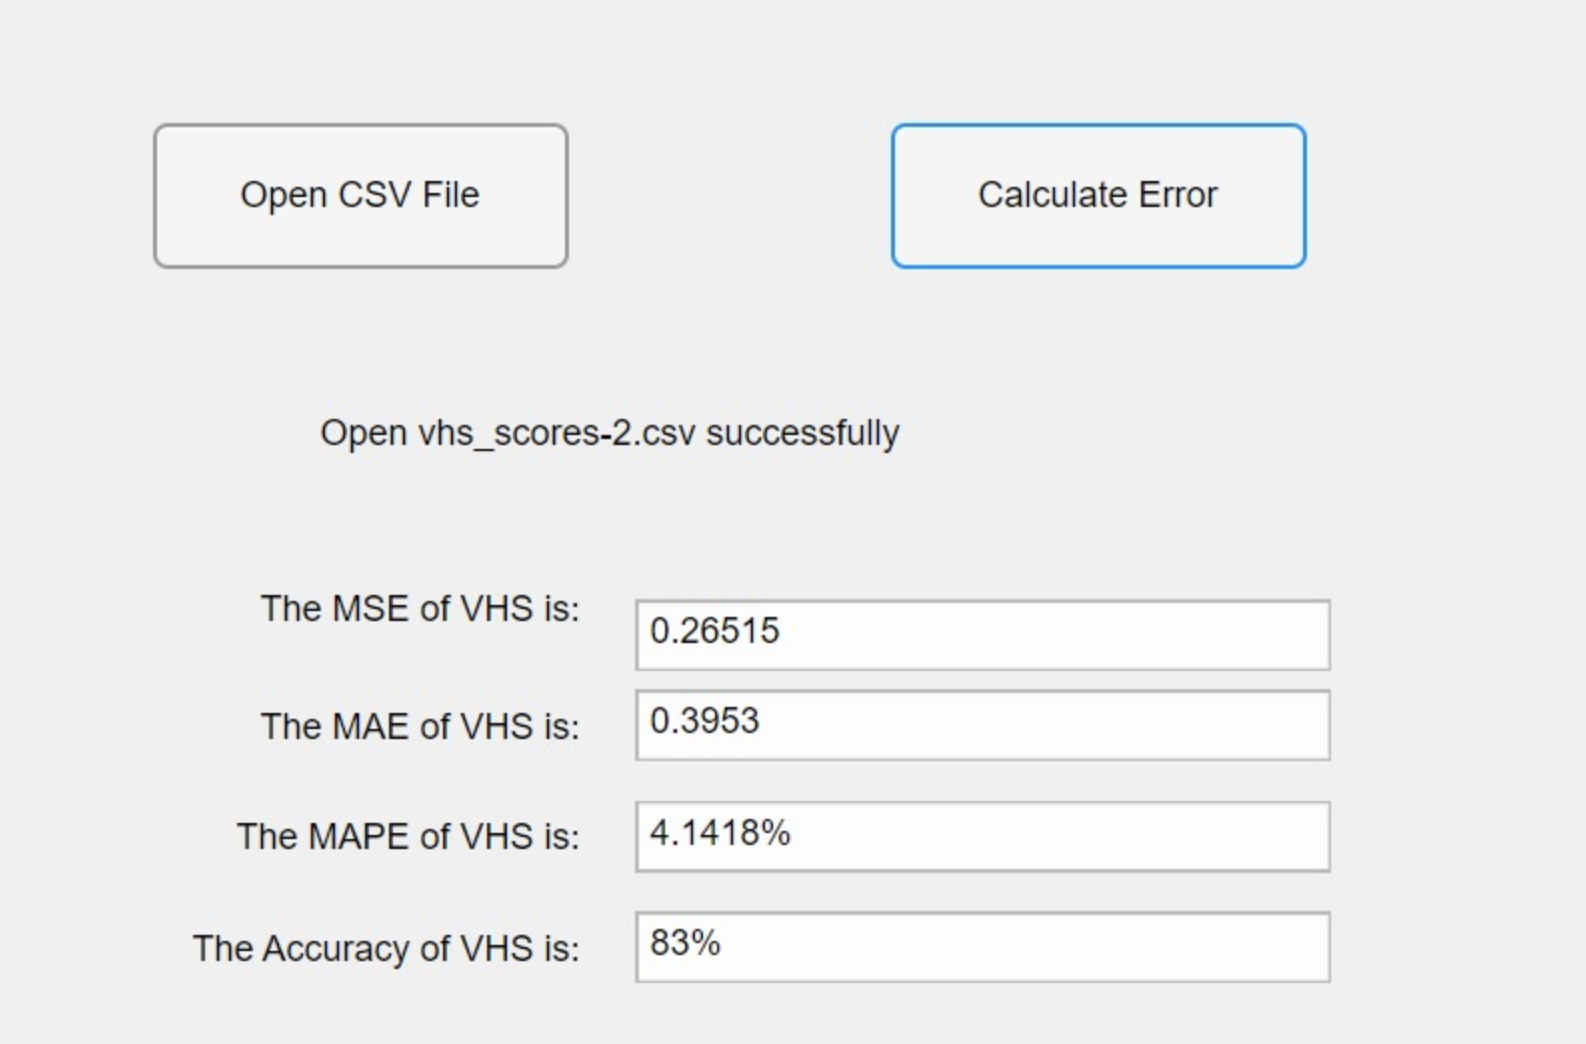

# 5. Show the comprison between predictions and ground truth
## You need to add the title with: image name, predicted VHS and Ground Truth VHS
<p align="center">
  <img src="Com.png" width="60%">
</p>


# Please show the comprison results of images: 1420.png, 1479.png and 1530.png from Valid dataset

<ipython-input-19-32c419cbde74>:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/best_convnext_keypoints-2.pth"))  # Load pretrai

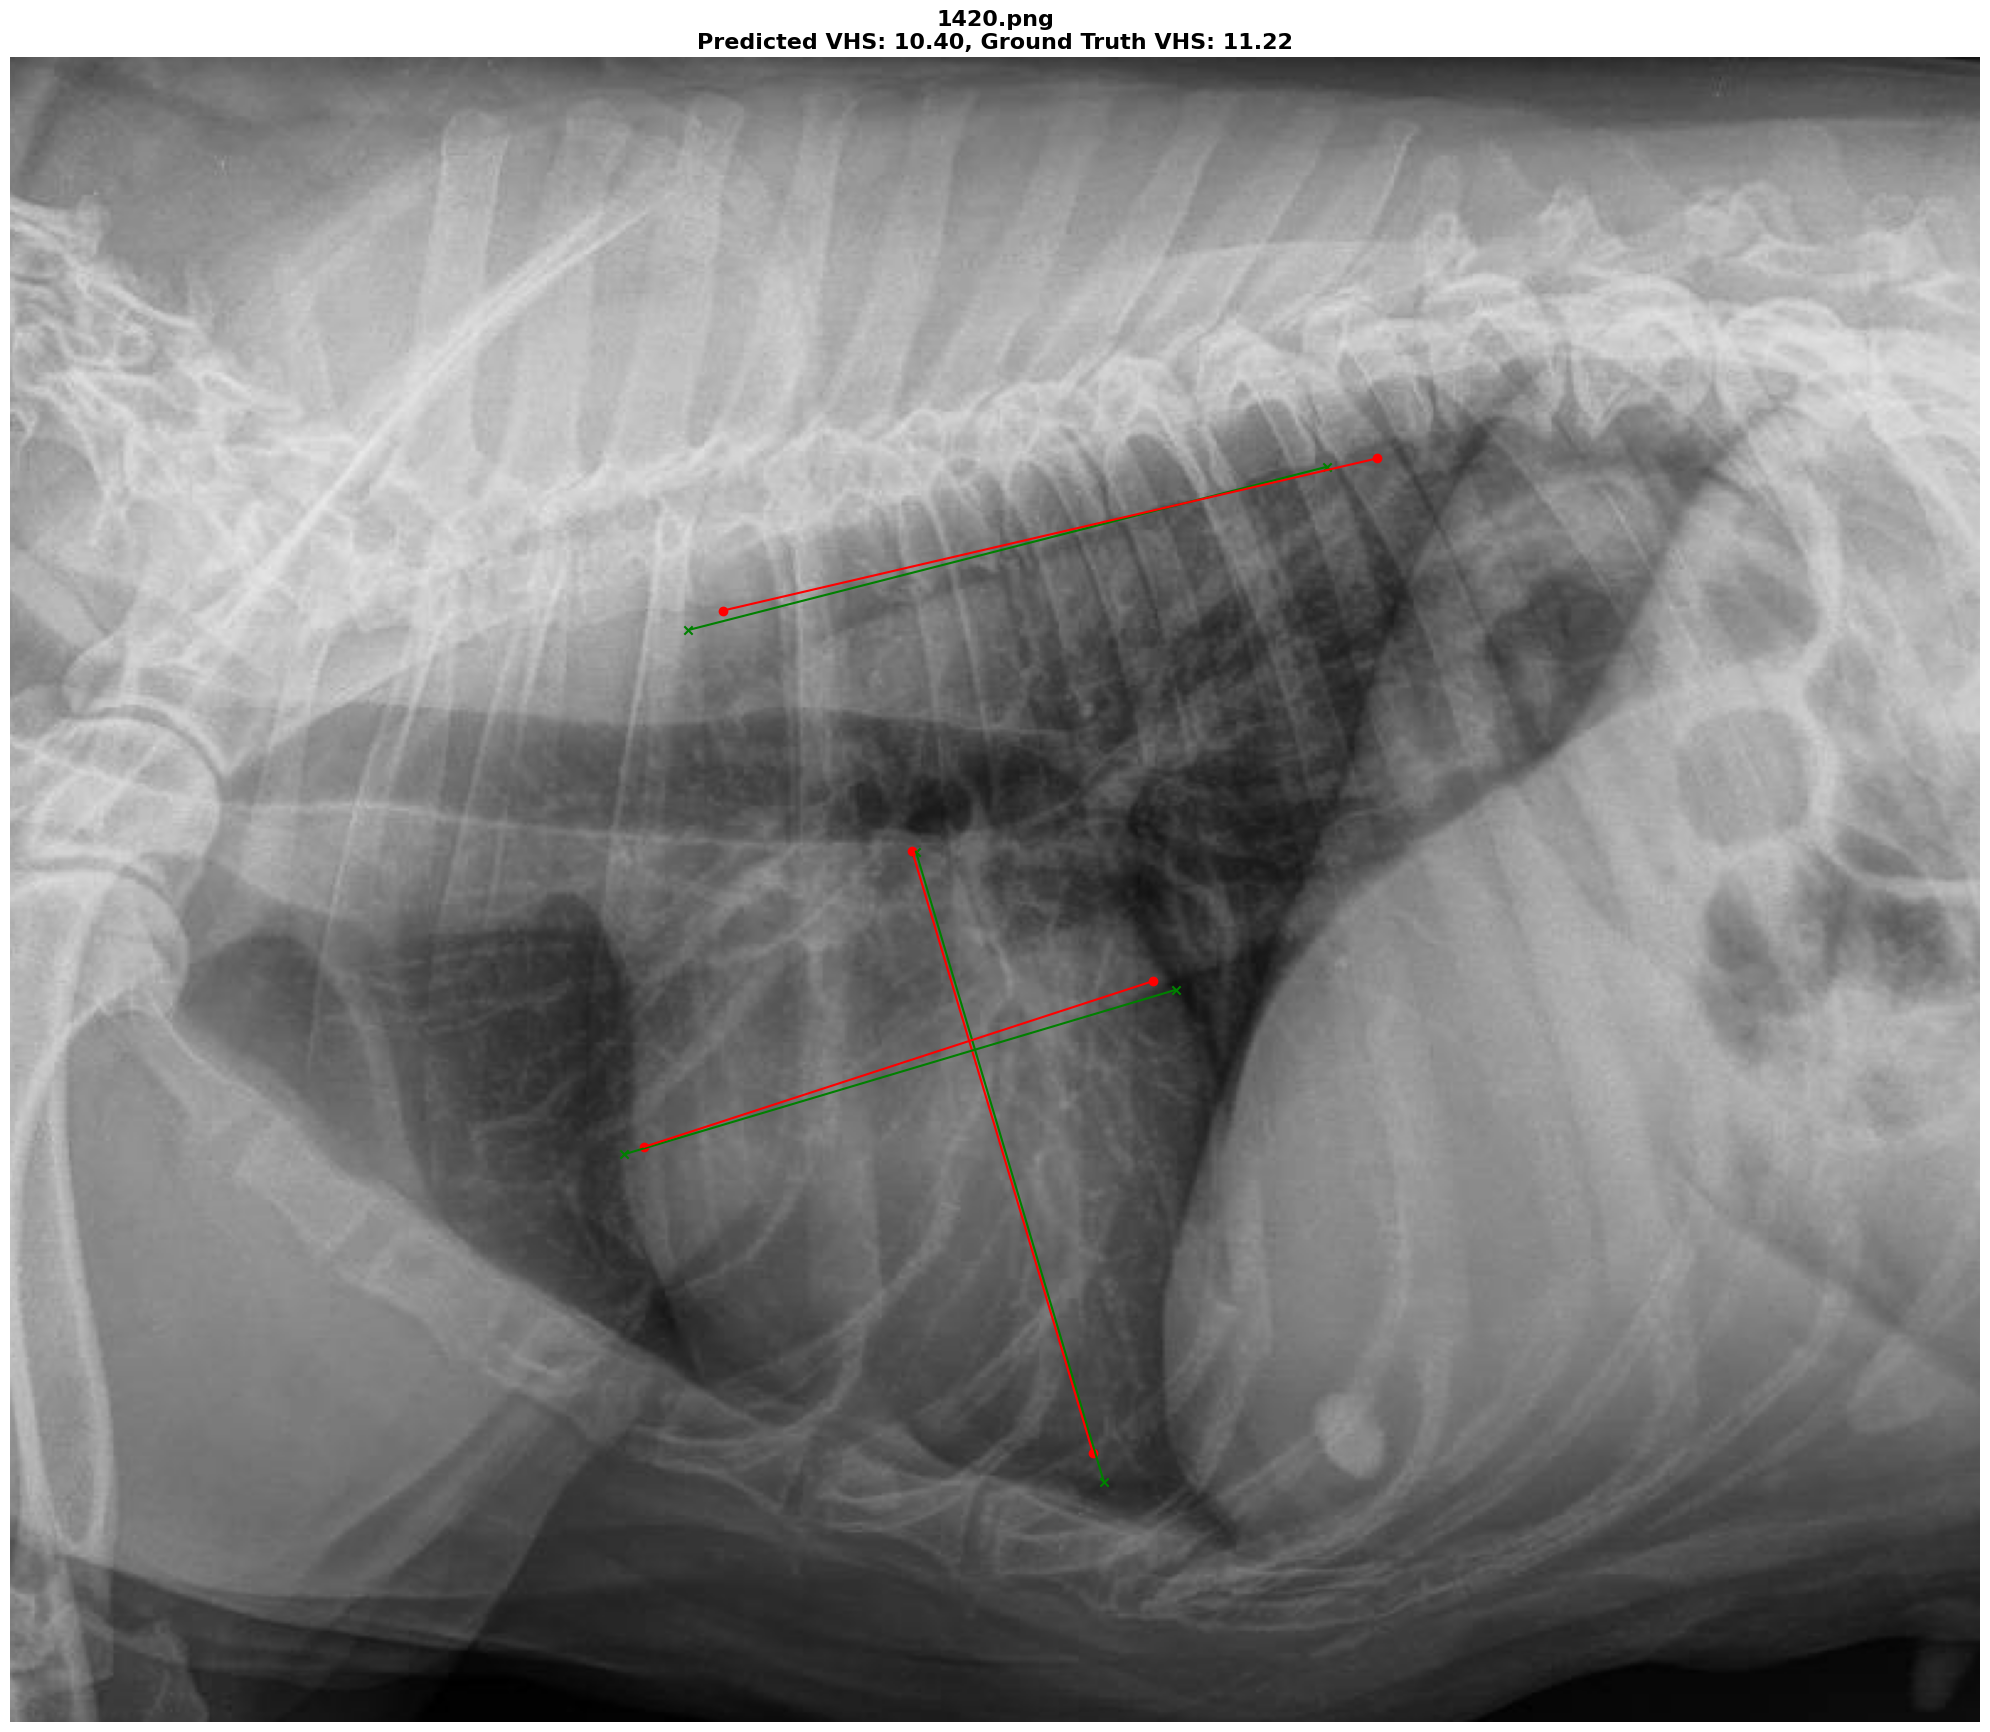

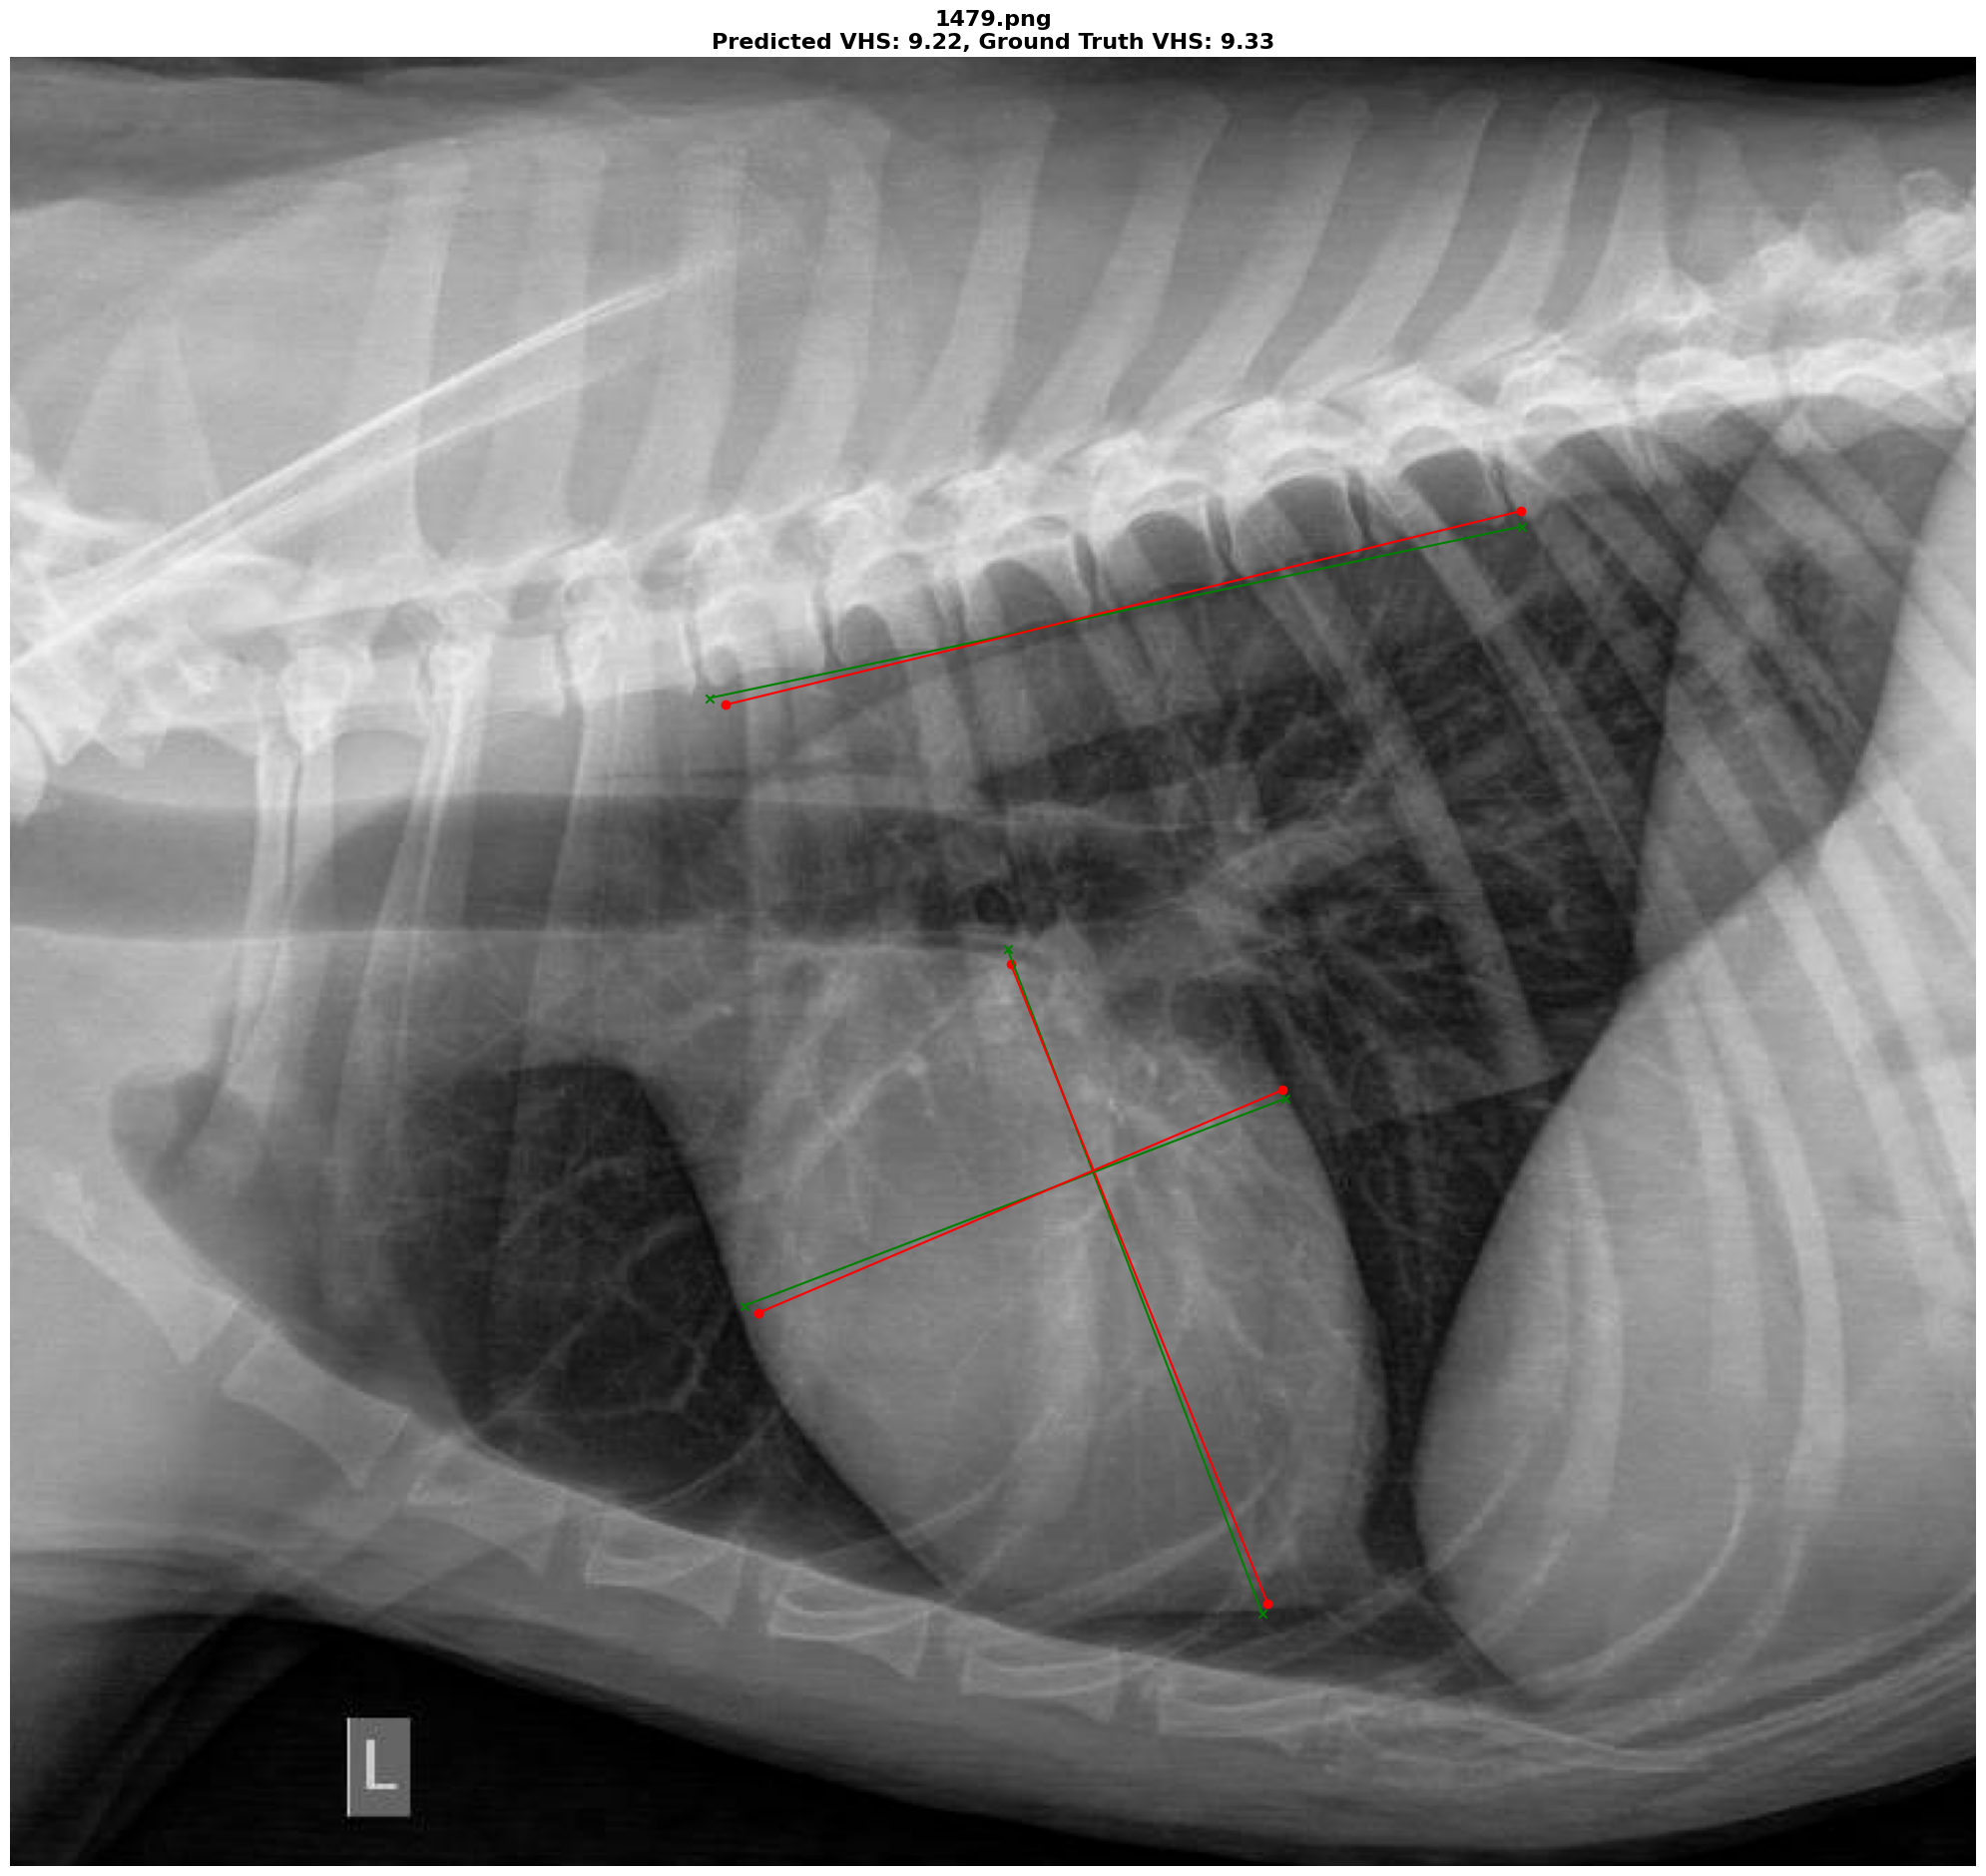

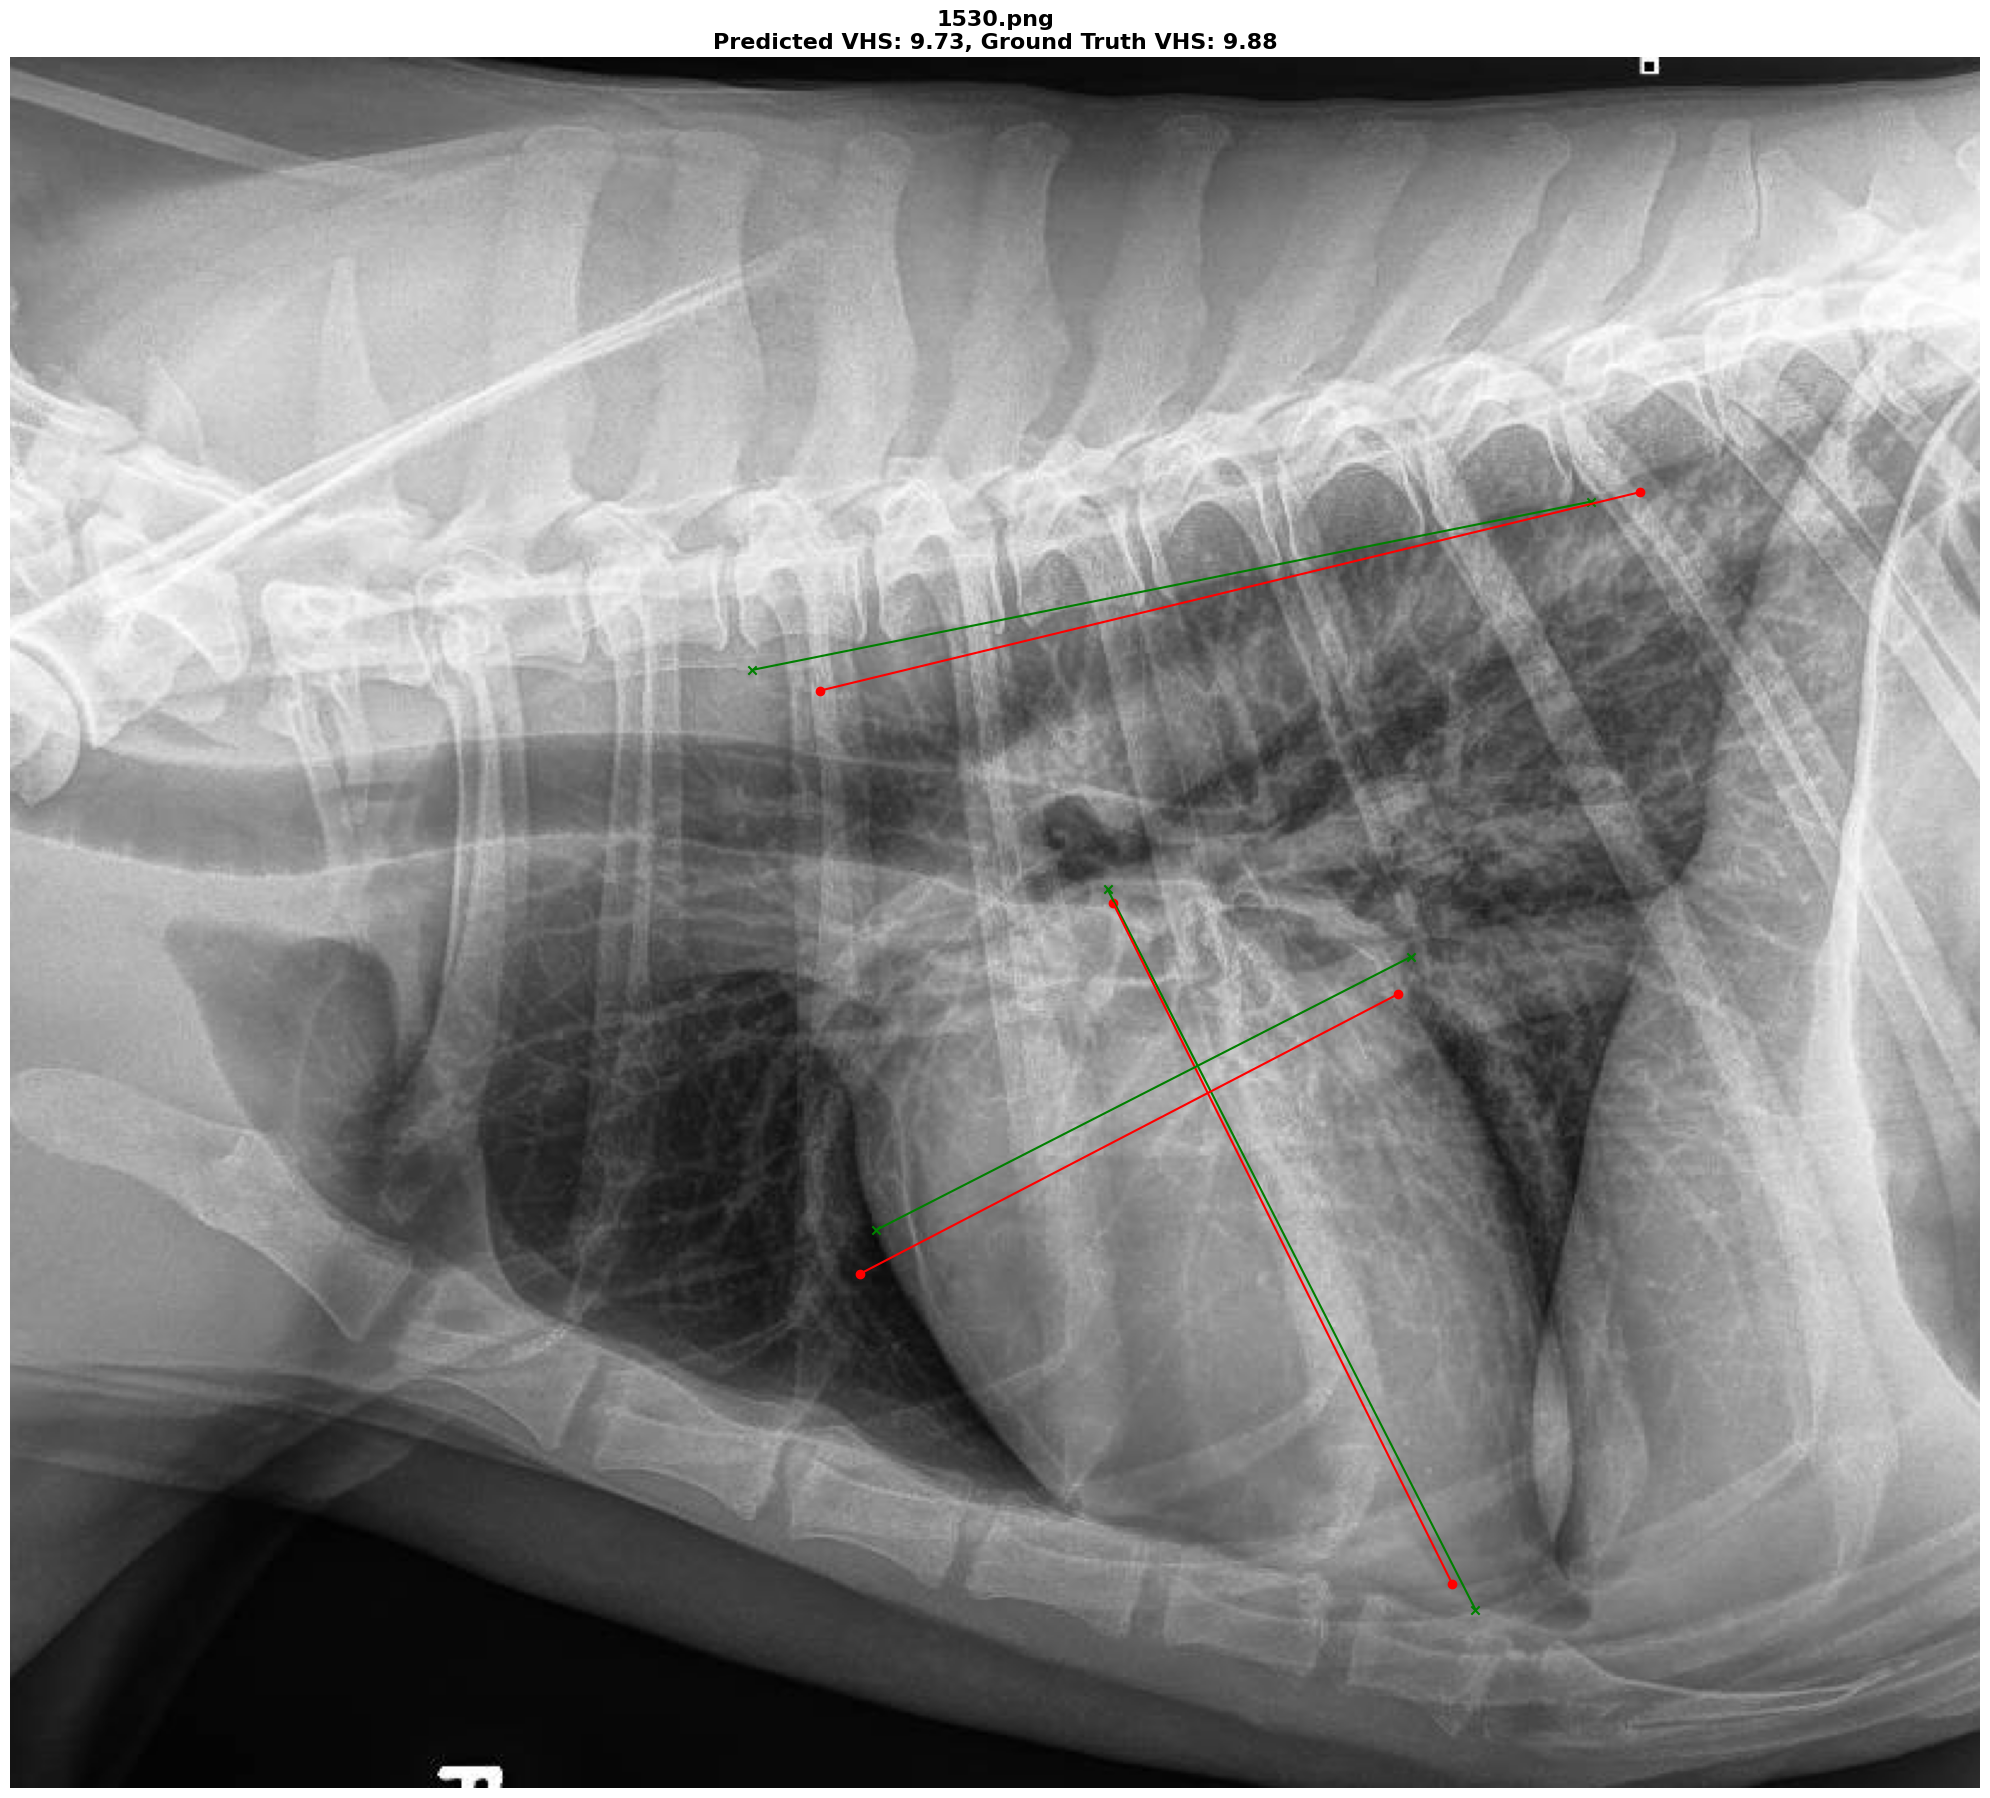

In [19]:
import torch
import torch.nn as nn
from timm import create_model
from torchvision import transforms as T
import os
from PIL import Image
from scipy.io import loadmat
import matplotlib.pyplot as plt

# Define the ConvNeXt keypoint regression model
class ConvNeXtKeypointRegressor(nn.Module):
    def __init__(self, pretrained=True, num_keypoints=12):
        super(ConvNeXtKeypointRegressor, self).__init__()
        self.backbone = create_model('convnext_base', pretrained=pretrained, num_classes=0)
        in_features = self.backbone.num_features
        self.regression_head = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_keypoints)
        )

    def forward(self, x):
        features = self.backbone(x)
        keypoints = self.regression_head(features)
        return keypoints


# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvNeXtKeypointRegressor(pretrained=True, num_keypoints=12).to(device)
model.load_state_dict(torch.load("/content/best_convnext_keypoints-2.pth"))  # Load pretrained weights
model.eval()

# Define transformations
def get_transform(resized_image_size):
    return T.Compose([
        T.Resize((resized_image_size, resized_image_size)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

# Function to visualize predictions
def visualize_predictions(image_path, label_path, model, transform, device, ax):
    image = Image.open(image_path).convert("RGB")
    width, height = image.size
    transformed_image = transform(image).unsqueeze(0).to(device)

    label_data = loadmat(label_path)
    gt_points = label_data['six_points'].astype(float)
    gt_vhs = label_data['VHS'].astype(float).item()

    with torch.no_grad():
        predicted_points = model(transformed_image).cpu().numpy().reshape(6, 2)
        predicted_points = predicted_points * resized_image_size
        predicted_points[:, 0] = width / resized_image_size * predicted_points[:, 0]
        predicted_points[:, 1] = height / resized_image_size * predicted_points[:, 1]
        predicted_vhs = calculate_vhs(predicted_points)  # Define this function for VHS calculation

    ax.imshow(image)
    ax.scatter(gt_points[:, 0], gt_points[:, 1], c='green', marker='x', label='Ground Truth')
    ax.scatter(predicted_points[:, 0], predicted_points[:, 1], c='red', marker='o', label='Predicted')

    # Connect points for visualization
    for (p1, p2) in [(0, 1), (2, 3), (4, 5)]:
        ax.plot([gt_points[p1, 0], gt_points[p2, 0]], [gt_points[p1, 1], gt_points[p2, 1]], 'g')
        ax.plot([predicted_points[p1, 0], predicted_points[p2, 0]], [predicted_points[p1, 1], predicted_points[p2, 1]], 'r')

    ax.set_title(f"{os.path.basename(image_path)}\nPredicted VHS: {predicted_vhs:.2f}, Ground Truth VHS: {gt_vhs:.2f}", fontsize=16, weight='bold')
    ax.axis('off')
    ax.set_aspect('equal')

# Parameters
image_names = ["1420.png", "1479.png", "1530.png"]
valid_root = '/content/drive/MyDrive/Project 2 Neural Net/Valid'
resized_image_size = 300

# Visualization loop
for image_name in image_names:
    fig, ax = plt.subplots(figsize=(20, 20))
    image_path = os.path.join(valid_root, "Images", image_name)
    label_path = os.path.join(valid_root, "Labels", image_name.replace(".png", ".mat"))
    visualize_predictions(image_path, label_path, model, get_transform(resized_image_size), device, ax)
    plt.tight_layout()
    plt.show()


# 6. Write a three-page report using LaTex and upload your paper to ResearchGate or Arxiv, and put your paper link here.


https://drive.google.com/file/d/1zMDJJTf-M-1LGPxpqQPiriRKkYZ3saZN/view?usp=sharing